# Video pipeline demonstrating applying labels based on timestamps or frame numbers

### Goal
In this example, we will go through the creation of a pipeline using the VideoReader operator to read videos along with their labels. We will apply labels to the video based on frame numbers as input, and read timestamp and frame number labels along with decoded video frames.

For more information on the VideoReader parameters, please look at the documentation reference.

To make it clearer, let's look at how we can obtain these sequences and how to use them!


First let's import the libraries.

In [1]:
import os
import numpy as np
import tempfile

In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

try:
    from PIL import Image
    has_PIL = True
except ImportError:
    has_PIL = False

Then we define that in each iteration of the pipeline we want 4 batches and each batch has sequence length of 1 frame. We want to run 10 iterations for illustrative purpose.

In [3]:
BATCH_SIZE=4
COUNT=1
ITER=10
frame_num_based_labels=True

The video we have used in this example is a 10 seconds long, 25fps, 512x512 resolution video with timestamp burned into the frame itself in the top half of the video and frame number in the bottom half. The burned text in the decoded frame can be easily used to verify that we are indeed returned the correct frame number and timestamp labels.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [4]:
dali_extra_path = os.environ['DALI_EXTRA_PATH']
file_list_txt = dali_extra_path +  "/db/video/test_label.mp4 0\n"
file_list_txt += dali_extra_path + "/db/video/test_label.mp4 1 0 100\n"
file_list_txt += dali_extra_path + "/db/video/test_label.mp4 2 100 200\n"
file_list_txt += dali_extra_path + "/db/video/test_label.mp4 3 200 250\n"
tf = tempfile.NamedTemporaryFile()
tf.write(str.encode(file_list_txt))
tf.flush()

### Defining the pipeline
We can then define a minimal Pipeline that will output directly the VideoReader outputs.

Notice that we set `file_list_frame_num=True`, this means that the labels we provided above using `file_list` will be interpreted as frame numbers.
`test_label.mp4 1 0 100` is interpreted as applying label `1` from frame number `0` to `100`(excluding).

If however you wished to apply labels using timestamp, simply set `file_list_frame_num=False` (default behaviour), and provide timestamps you wish to apply the label to. For example, if you wished to apply a label `1` to frames from `3` seconds to `8.5` seconds: `test_label.mp4 1 3 8.5`

In this example we have set both `enable_frame_num` and `enable_timestamps` to `True` for illustrative purpose. You can enable or disable either of them depending on your particular use case.

In [5]:
class VideoPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data):
        super(VideoPipe, self).__init__(batch_size, num_threads, device_id, seed=120)
        self.input = ops.VideoReader(device="gpu", file_list = data, sequence_length=COUNT,
                                     shard_id=0, num_shards=1, random_shuffle=True, initial_fill=10,
                                     image_type=types.RGB, dtype=types.FLOAT,
                                     file_list_frame_num=frame_num_based_labels, enable_frame_num=True, enable_timestamps=True)

    def define_graph(self):
        output = self.input(name="Reader")
        return output

### Visualizing the results
We will use matplotlib to display the frames we obtained and the associated labels.

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

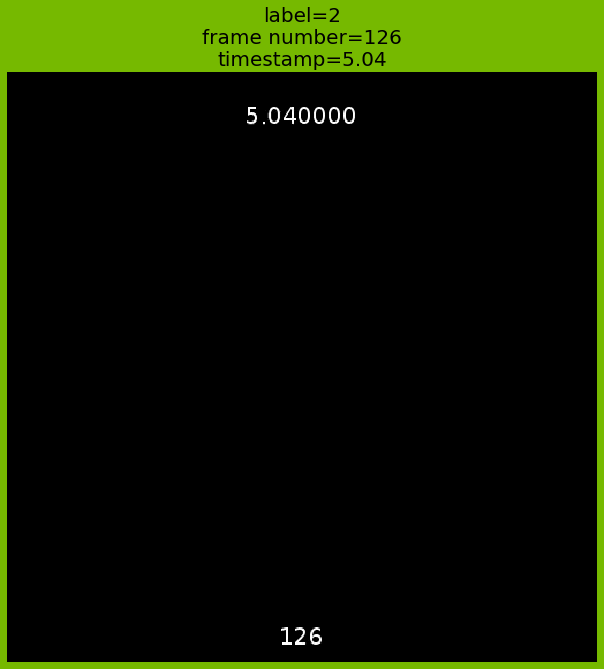

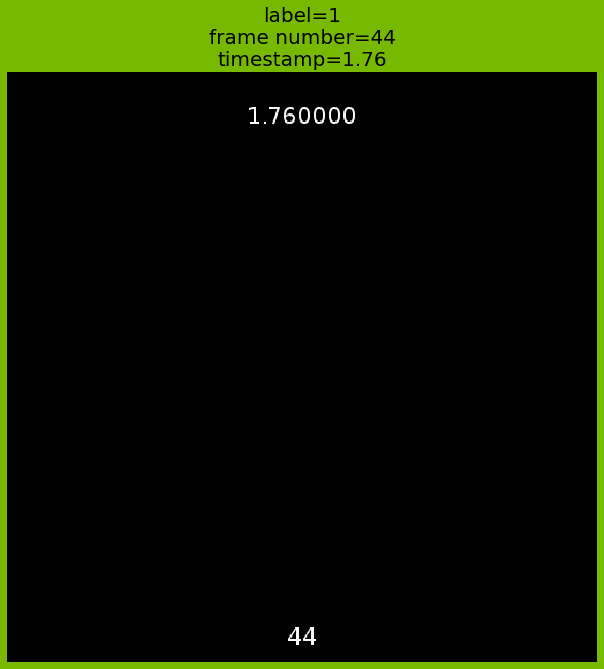

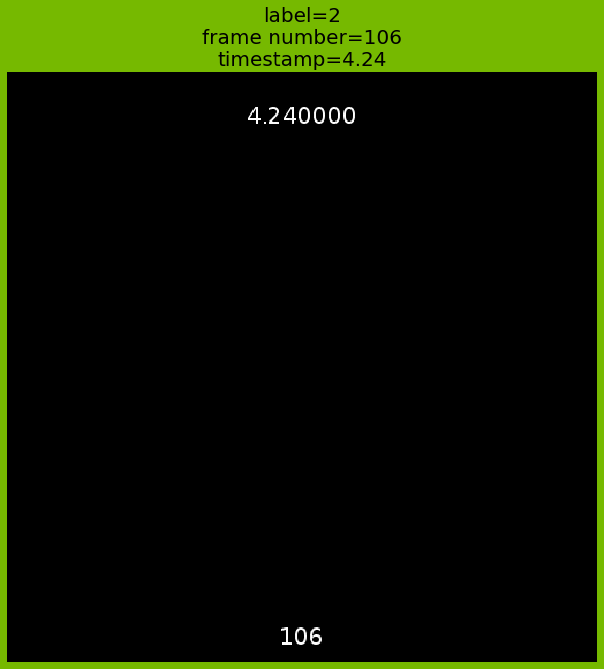

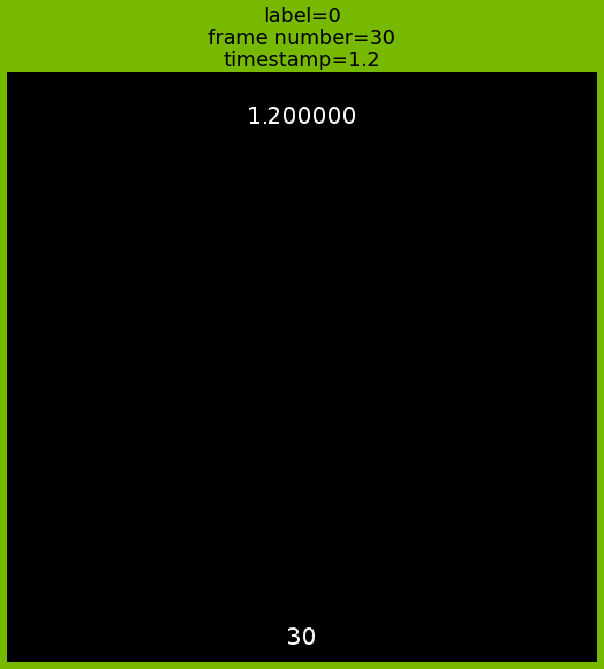

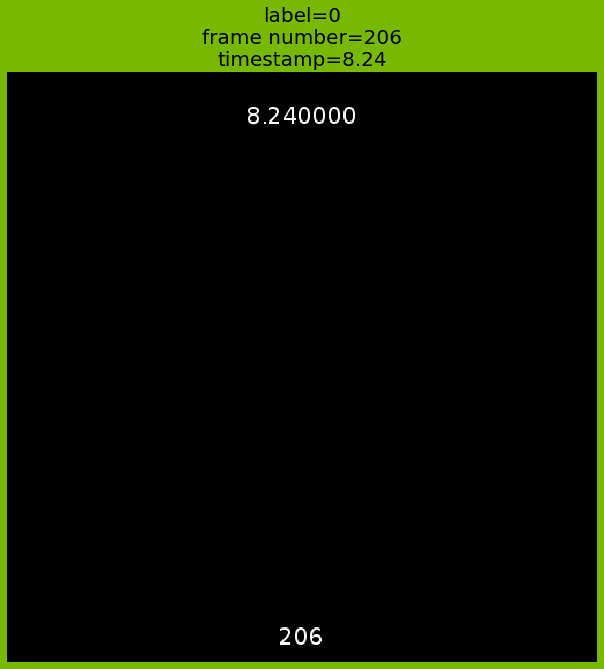

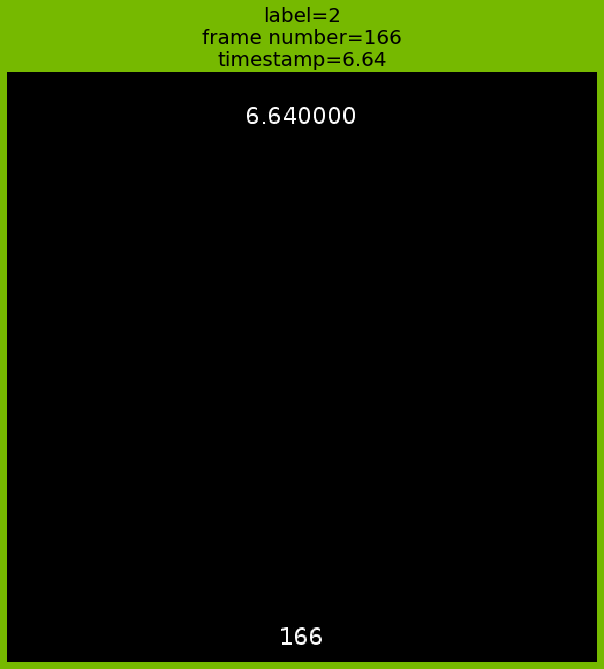

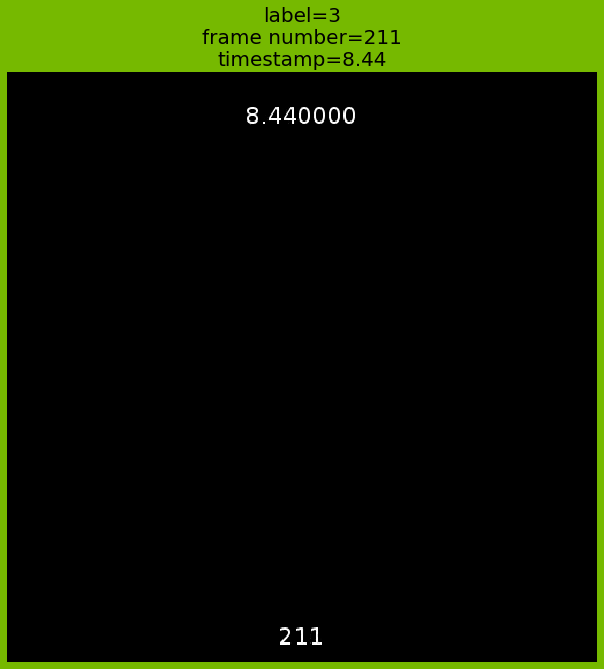

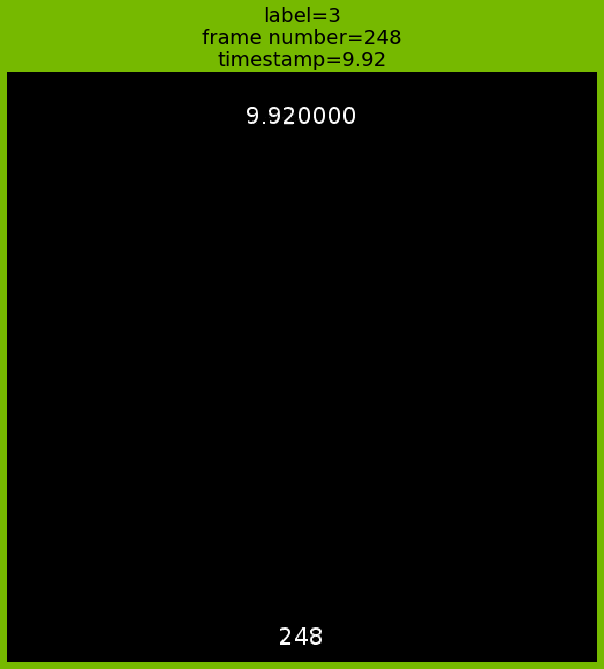

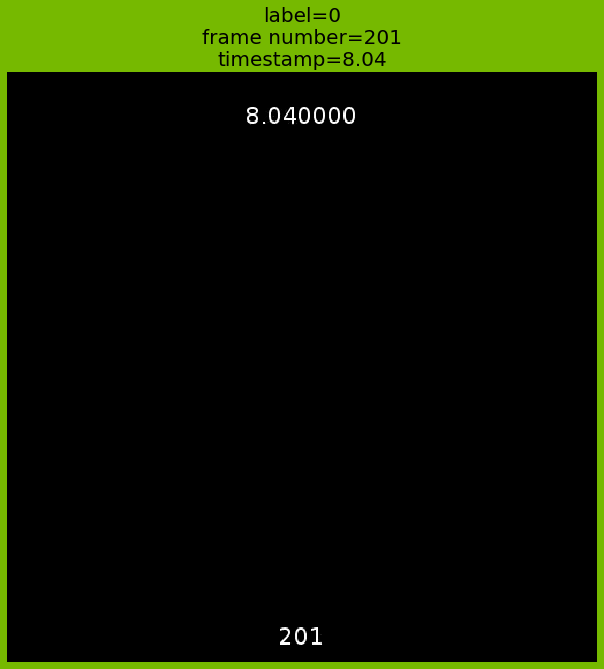

In [7]:
pipe = VideoPipe(batch_size=BATCH_SIZE, num_threads=2, device_id=0, data=tf.name)
pipe.build()
gs = gridspec.GridSpec(ITER, 1)

for i in range(ITER):
    sequences_out, label, start_frame_num, timestamps = pipe.run()
    sequences_out = sequences_out.as_cpu().as_array()
    label  = label.as_cpu().as_array()
    start_frame_num = start_frame_num.as_cpu().as_array()
    timestamps = timestamps.as_cpu().as_array()
    batch_sequences = sequences_out[0]
    sample_frame = batch_sequences[0]
    if has_PIL:
        im = Image.fromarray(sample_frame.astype('uint8'))
        fig = plt.figure(figsize = (16,128), facecolor="#76b900")
        plt.subplot(gs[i])
        plt.axis("off")
        plt.title("label=" + str(label[0][0]) + '\n'
                  "frame number=" + str(start_frame_num[0][0]) + '\n'
                  "timestamp=" + str(round(timestamps[0][0], 2)), fontsize=20)
        plt.imshow(im)
plt.close()
tf.close()